## Weather Forecasting with Bayesian Network

#### Préparation des données

La préparation des données ainsi que leur discrétisation pour le réseau bayésien a donné lieu à plusieurs recherches afin de comprendre plus précisément le sujet.
- L'humidité est toujours en 0 et 1 (c'est un %)
- La vitesse du vent est généralement comprise entre 1 et 70 km/h
- La visibilité varie entre moins d'1 km et plus de 40km


In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data/weatherHistory.csv')

data = data.dropna()  # we have more than 10000 rows, we only have 517 rows with missing values, so we can drop them

data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data['Date'] = data['Formatted Date'].dt.date

data_grouped = data.groupby('Date').agg({
    'Summary': lambda x: x.mode()[0],
    'Precip Type': 'first',
    'Temperature (C)': 'median', 
    'Apparent Temperature (C)': 'median',
    'Humidity': 'mean',
    'Wind Speed (km/h)': 'mean',
    'Visibility (km)': 'mean',
}).reset_index()


data_grouped['Temperature (C)'] = data_grouped['Temperature (C)'].apply(lambda x: int(x))


data_grouped['Apparent Temperature (C)'] = data_grouped['Apparent Temperature (C)'].apply(lambda x: int(x))
data_grouped['Humidity_discrete'] = pd.cut(data_grouped['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])
data_grouped['WindSpeed_discrete'] = pd.cut(data_grouped['Wind Speed (km/h)'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
data_grouped['Visibility_discrete'] = pd.cut(data_grouped['Visibility (km)'], bins=[0, 4, 10, data_grouped['Visibility (km)'].max()], labels=['Poor', 'Medium', 'High'], include_lowest=True)

data_grouped['Humidity_discrete'] = pd.cut(data_grouped['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])

temp_min = data_grouped['Temperature (C)'].min()
temp_max = data_grouped['Temperature (C)'].max()
bins = np.arange(temp_min, temp_max + 2, 2)

data_grouped['Temperature_discrete'] = pd.cut(data_grouped['Temperature (C)'], bins=bins, labels=[f'{x}-{x+2}' for x in bins[:-1]], include_lowest=True)

data_discrete= data_grouped.drop(columns=['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)']).set_index('Date')

data_discrete = data_discrete.rename(columns={
    'Temperature_discrete': 'Temperature',
    'Humidity_discrete': 'Humidity',
    'WindSpeed_discrete': 'WindSpeed',
    'Visibility_discrete': 'Visibility',
    'Summary': 'Summary'
})

summary_categories = data_discrete['Summary'].unique()

data_discrete.head()

,Summary,Precip Type,Humidity,WindSpeed,Visibility,Temperature
Date,,,,,,
2005-12-31,Partly Cloudy,rain,High,Medium,Medium,-1-1
2006-01-01,Mostly Cloudy,rain,High,Medium,High,3-5
2006-01-02,Overcast,rain,High,Medium,Medium,3-5
2006-01-03,Overcast,rain,High,Very Low,Medium,1-3
2006-01-04,Overcast,rain,High,Low,Medium,1-3


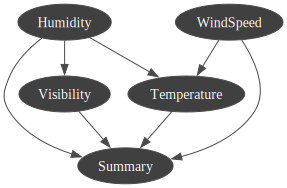

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

bn = gum.BayesNet('WeatherPrediction')

temp = bn.add(gum.LabelizedVariable('Temperature', 'Température', len(bins)))
hum = bn.add(gum.LabelizedVariable('Humidity', 'Humidité', 3))
wind = bn.add(gum.LabelizedVariable('WindSpeed', 'Vitesse du vent', 5))
visib = bn.add(gum.LabelizedVariable('Visibility', 'Visibilité', 3))
summary = bn.add(gum.LabelizedVariable('Summary', 'Résumé',len(summary_categories)))

bn.addArc(wind, temp) 
bn.addArc(hum, visib) 
bn.addArc(hum, temp)
bn.addArc(hum, summary)
bn.addArc(wind, summary)
bn.addArc(visib, summary)
bn.addArc(temp, summary)

gnb.showBN(bn)


In [3]:
category_mappings = {
    'Visibility': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Humidity': {'Low': 0, 'Medium': 1, 'High': 2},
    'WindSpeed': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Temperature':{f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Summary': {summary_categories[i] : i for i in range(len(summary_categories))},
    }

for column, mapping in category_mappings.items():
    data_discrete[column] = data_discrete[column].map(mapping)

print(data_discrete.head())


            Summary Precip Type Humidity WindSpeed Visibility Temperature
Date                                                                     
2005-12-31        0        rain        2         2          1           8
2006-01-01        1        rain        2         2          2          10
2006-01-02        2        rain        2         2          1          10
2006-01-03        2        rain        2         0          1           9
2006-01-04        2        rain        2         1          1           9


In [4]:
learner = gum.BNLearner(data_discrete, bn)

learner.useSmoothingPrior(0.5)
bn_learned = learner.learnParameters(bn)

# print(bn.cpt('Summary')) #différence entre bn et bn_learned
gnb.showPotential(bn_learned.cpt("Temperature"))

In [13]:
## Pour le test, on va prendre une ligne du dataset et essayer de prédire le temps qu'il fera
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

ie = gum.LazyPropagation(bn_learned)

ie.setEvidence({
    "Temperature": 6,  # Exemple de valeur discrétisée
    "Humidity": 1,     # Exemple de valeur pour 'Medium' dans Humidity
    "WindSpeed": 2,     # Exemple de valeur pour 'High' dans WindSpeed
    "Visibility": 2
})

ie.makeInference()

posterior_summary = ie.posterior("Summary")
predicted_summary, percentage = posterior_summary.argmax()[0][0], posterior_summary.argmax()[1]

predicted_summary: dict = predicted_summary.get("Summary")

# Inverser le dictionnaire pour retrouver la catégorie initiale à partir de l'index
inverse_summary_mapping = {v: k for k, v in category_mappings['Summary'].items()}
most_likely_category = inverse_summary_mapping[predicted_summary]

print(f"Le temps sera {most_likely_category} avec une probabilité de {percentage * 100:.2f}%")



Le temps sera Partly Cloudy avec une probabilité de 16.67%
